# Overview

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from pmdarima.arima import auto_arima
from gensim.models import KeyedVectors
import tensorflow as tf
import spacy
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from pylab import rcParams
import re

rcParams['figure.figsize'] = 10, 5
pd.options.mode.chained_assignment = None
%matplotlib inline

In [3]:
items = pd.read_csv("./data/items.csv")
shops = pd.read_csv("./data/shops.csv")
item_categories = pd.read_csv("./data/item_categories.csv")
train = pd.read_csv("./data/sales_train.csv")
test = pd.read_csv("./data/test.csv")

In [4]:
items

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62


In [5]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [6]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [7]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


In [8]:
test

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


In [9]:
# Check missing values
print("items:\n" + str(items.isna().sum()) + "\n")
print("train:\n" + str(train.isna().sum()) + "\n")
print("test:\n" + str(test.isna().sum()) + "\n")

items:
item_name           0
item_id             0
item_category_id    0
dtype: int64

train:
date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

test:
ID         0
shop_id    0
item_id    0
dtype: int64



# Preprocessing

## train

In [10]:
print(f"The number of shops: {train['shop_id'].unique().shape[0]}")
print(f"The number of items: {train['item_id'].unique().shape[0]}")

The number of shops: 60
The number of items: 21807


### Format: date

In [11]:
train["date"] = pd.to_datetime(train["date"], format="%d.%m.%Y")

### Anomalies in item_price column

In [12]:
train[train['item_price'] < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,2013-05-15,4,32,2973,-1.0,1.0


In [13]:
train[(train['date'] == "2013-5-15") & (train['item_id'] == 2973)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
453034,2013-05-15,4,25,2973,1249.5,1.0
469026,2013-05-15,4,46,2973,1249.5,1.0
469951,2013-05-15,4,45,2973,1249.0,1.0
484683,2013-05-15,4,32,2973,-1.0,1.0


In [14]:
missing_price = train[(train['date'] == "2013-5-15") & (train['item_id'] == 2973) & (train['item_price'] > 0)]
train.loc[train['item_price'] < 0, "item_price"] = missing_price['item_price'].mean()

In [15]:
train[train['item_price'] < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day


### Anomalies in item_cnt_day column

In [16]:
negative_train = train[train['item_cnt_day'] < 0]

In [17]:
# Statistics: item_price
train['item_price'].describe()

count    2.935849e+06
mean     8.908537e+02
std      1.729800e+03
min      7.000000e-02
25%      2.490000e+02
50%      3.990000e+02
75%      9.990000e+02
max      3.079800e+05
Name: item_price, dtype: float64

In [18]:
# Statistics: item_price of records with item_cnt_day < 0
negative_train['item_price'].describe()

count     7356.000000
mean      1442.945623
std       2419.680132
min          0.500000
25%        349.000000
50%        799.000000
75%       1699.000000
max      33490.000000
Name: item_price, dtype: float64

In [19]:
train['item_cnt_day'] = np.where(train['item_cnt_day'] < 0, 0, train['item_cnt_day'])

### Select shops that appear in test set

In [20]:
print(f"The number of shops in train data: {train['shop_id'].unique().shape[0]}")
print(f"The number of shops in test data: {test['shop_id'].unique().shape[0]}")

The number of shops in train data: 60
The number of shops in test data: 42


In [53]:
# train = train[train['shop_id'].isin(test['shop_id'].unique().tolist())]
# train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,0.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0
2935845,2015-10-09,33,25,7460,299.00,1.0
2935846,2015-10-14,33,25,7459,349.00,1.0
2935847,2015-10-22,33,25,7440,299.00,1.0


### Date aggregation

In [54]:
# train = pd.merge(train, 
#                  train.groupby(by=['date_block_num', 'shop_id', 'item_id'])['item_cnt_day'].sum().to_frame('item_cnt_month').reset_index(),
#                  on=['date_block_num', 'shop_id', 'item_id'],
#                  how='left')
# train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_cnt_month
0,2013-01-02,0,59,22154,999.00,1.0,1.0
1,2013-01-03,0,25,2552,899.00,1.0,1.0
2,2013-01-05,0,25,2552,899.00,0.0,1.0
3,2013-01-06,0,25,2554,1709.05,1.0,1.0
4,2013-01-15,0,25,2555,1099.00,1.0,1.0
...,...,...,...,...,...,...,...
2413241,2015-10-10,33,25,7409,299.00,1.0,3.0
2413242,2015-10-09,33,25,7460,299.00,1.0,3.0
2413243,2015-10-14,33,25,7459,349.00,1.0,1.0
2413244,2015-10-22,33,25,7440,299.00,1.0,1.0


## test

In [21]:
print("Items appear in test set but not in train set:")
len(set(test["item_id"].unique().tolist()) - set(train["item_id"].unique().tolist()))

Items appear in test set but not in train set:


363

### Add date_block_num and item_price

In [22]:
test["date_block_num"] = 34
test

,ID,shop_id,item_id,date_block_num
0,0,5,5037,34
1,1,5,5320,34
2,2,5,5233,34
3,3,5,5232,34
4,4,5,5268,34
...,...,...,...,...
214195,214195,45,18454,34
214196,214196,45,16188,34
214197,214197,45,15757,34
214198,214198,45,19648,34


# Feature Engineering

## Text Embeddings

In [23]:
ru_model = KeyedVectors.load_word2vec_format('../wiki.ru.vec')

In [24]:
def extract_feature(text_col):
    features = list()
    len_lst = list()
    nlp = spacy.load("ru_core_news_lg")
    fail_count = 0
    
    for i in tqdm(range(text_col.shape[0])):
        one_feature = list()
        tokens = nlp (text_col[i])
        for token in tokens:
            try:
                one_feature.append(ru_model.get_vector(token.text))
            except:
                continue
        if len(one_feature) > 0:
            one_feature = np.stack(one_feature).flatten()
        else:
            one_feature = np.zeros(300)
            fail_count += 1
        features.append(one_feature)
        len_lst.append(one_feature.shape[0])
        
    med = int(pd.Series(len_lst).max())
    print(f"Max: {med}")
    feature_tp = list()
    for item in features:
        if item.shape[0] < med:
            item = np.concatenate([item, np.zeros(med - item.shape[0])])
        else:
            item = item[:med]
        feature_tp.append(item)
    
    print(f"Failed: {fail_count}")
    features = np.stack(feature_tp)
    return features

In [25]:
def encoding_cate(ser, num):
    ser_df = ser.value_counts().to_frame('count').reset_index()
    ser_df = ser_df.loc[ser_df['count'] > num, 'index']
    print(f"The number of classes: {ser_df.shape[0] + 1}")
    ser_df = pd.DataFrame({"cate": ser_df.tolist(), "index": list(range(ser_df.shape[0], 0, -1))})
    return ser.to_frame('cate').merge(ser_df, on='cate', how='left').fillna(0)['index'].astype(int)

### item_categories

In [26]:
item_categories_feature = extract_feature(item_categories['item_category_name'])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 84/84 [00:00<00:00, 311.90it/s]

Max: 1800
Failed: 1


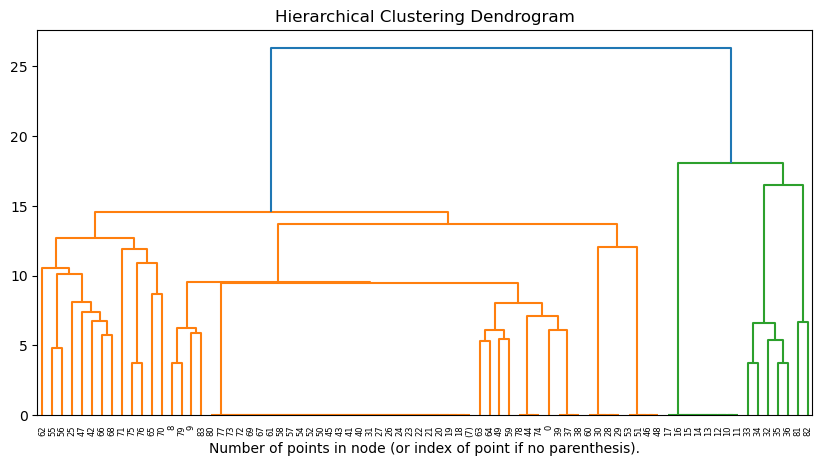

In [27]:
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    dendrogram(linkage_matrix, **kwargs)


clustering = AgglomerativeClustering(distance_threshold=8, n_clusters=None).fit(item_categories_feature)

plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(clustering, truncate_mode="level")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [28]:
print(f"The number of classes: {np.unique(clustering.labels_).shape[0]}")
print(f"Check the shape of labels: {clustering.labels_.shape[0]}")
print(f"Labels: {clustering.labels_}")

The number of classes: 17
Check the shape of labels: 84
Labels: [ 2  6  6  6  6  6  6  6  5  5 11 11 11 11 11 11 11 11  6  6  6  6  6  6
  6 15  6  6 16 16 16  6  3  3  3  3  3  2  2  2  6  6  0  6  2  6  9  0
  9  7  6  9  6  9  6 12 12  6  6  7 16  6 10  7  7 14  0  6  0  6 13  8
  6  6  2  4  4  6  2  5  6  1  1  5]


In [29]:
item_categories['item_category_te'] = clustering.labels_
item_categories = item_categories.drop(columns=['item_category_name'])
item_categories

,item_category_id,item_category_te
0,0,2
1,1,6
2,2,6
3,3,6
4,4,6
...,...,...
79,79,5
80,80,6
81,81,1
82,82,1


### shops

In [30]:
shops_feature = extract_feature(shops['shop_name'])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 302.40it/s]

Max: 1500
Failed: 2


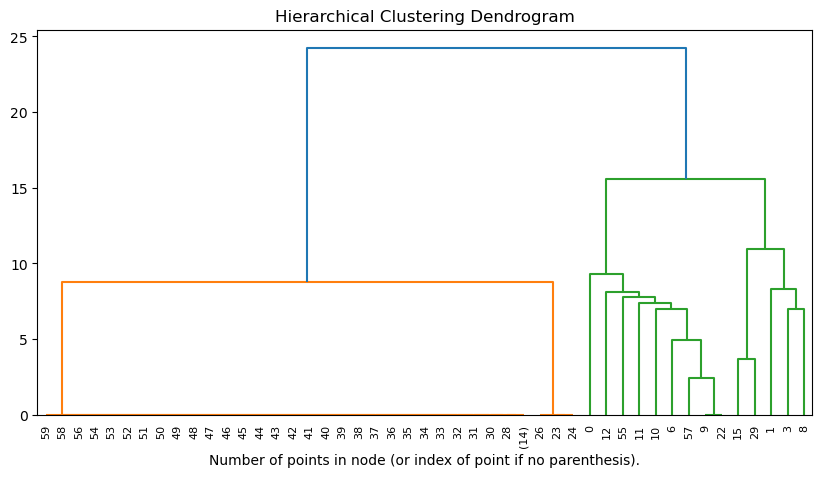

In [31]:
clustering = AgglomerativeClustering(distance_threshold=8, n_clusters=None).fit(shops_feature)

plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(clustering, truncate_mode="level")
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [32]:
print(f"The number of classes: {np.unique(clustering.labels_).shape[0]}")
print(f"Check the shape of labels: {clustering.labels_.shape[0]}")
print(f"Labels: {clustering.labels_}")

The number of classes: 8
Check the shape of labels: 60
Labels: [4 6 5 1 5 5 0 5 1 0 0 0 7 5 5 3 5 5 5 5 5 5 0 2 2 5 2 5 5 3 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 0 5 0 5 5]


In [33]:
shop_name = shops['shop_name'].str.split(pat=' ', n=2)
def remove_stopping_words(lst):
    new_lst = list()
    for i in lst:
        i = i.strip(',?!"()')
        i = re.sub('"', '', i)
        i = re.sub('\(', '', i)
        if i != "":
            new_lst.append(i)
    return new_lst

shop_name_split = shop_name.apply(remove_stopping_words)
shop_city = shop_name_split.apply(lambda x: x[0])
shop_info = shop_name_split.apply(lambda x: x[1])

In [34]:
shops['city'] = pd.factorize(shop_city)[0]
shops['info'] = encoding_cate(shop_info, 1)
shops['shop_te'] = clustering.labels_
shops = shops.drop(columns=['shop_name'])
shops.head()

The number of classes: 7


,shop_id,city,info,shop_te
0,0,0,2,4
1,1,0,6,6
2,2,1,6,5
3,3,2,4,1
4,4,3,6,5


### items

In [35]:
# The first word in item name
first_word = items['item_name'].str.split(pat=' ').apply(lambda x: x[0])
first_word = encoding_cate(first_word, 3)
first_word

The number of classes: 1224


0        0
1        0
2        0
3        0
4        0
        ..
22165    0
22166    0
22167    0
22168    0
22169    0
Name: index, Length: 22170, dtype: int64

In [36]:
# Information about the item in ()
def trans_lst(col):
    if len(col) > 0:
        item = col[0]
        item = item.lower()
        item = re.sub("\s", "", item)
        item = item.strip("\[\s\t\n")
    else:
        item = ""
    return item

item_addons = items['item_name'].str.findall(r'\((.+?)\)').apply(trans_lst)
item_addons = encoding_cate(item_addons, 35)
item_addons

The number of classes: 27


0         0
1        26
2         0
3         0
4         0
         ..
22165    26
22166    26
22167     0
22168    26
22169     0
Name: index, Length: 22170, dtype: int64

In [37]:
# Information about the item in []
item_addons_2 = items['item_name'].str.findall(r'\[(.+?)[,\]...]').apply(trans_lst)
item_addons_2 = encoding_cate(item_addons_2, 10)
item_addons_2

The number of classes: 14


0        13
1        12
2        13
3        13
4        13
         ..
22165    12
22166     9
22167    13
22168    13
22169    13
Name: index, Length: 22170, dtype: int64

In [38]:
items['first_word'] = first_word
items['item_addons'] = item_addons
items['item_addons_2'] = item_addons_2
items = items.drop(columns=['item_name'])
items

,item_id,item_category_id,first_word,item_addons,item_addons_2
0,0,40,0,0,13
1,1,76,0,26,12
2,2,40,0,0,13
3,3,40,0,0,13
4,4,40,0,0,13
...,...,...,...,...,...
22165,22165,31,0,26,12
22166,22166,54,0,26,9
22167,22167,49,0,0,13
22168,22168,62,0,26,13


## Structural Embeddings

### Date

### Price

### Lag

In [57]:
test["item_price"] = np.NaN
price = pd.concat([train[['date_block_num', 'shop_id', 'item_id', 'item_price']],
                   test[['date_block_num', 'shop_id', 'item_id', 'item_price']]],
                  axis=0)
price

,date_block_num,shop_id,item_id,item_price
0,0,59,22154,999.00
1,0,25,2552,899.00
2,0,25,2552,899.00
3,0,25,2554,1709.05
4,0,25,2555,1099.00
...,...,...,...,...
214195,34,45,18454,NaN
214196,34,45,16188,NaN
214197,34,45,15757,NaN
214198,34,45,19648,NaN


In [58]:
price = price.groupby(by=['date_block_num', 'item_id'])['item_price'].mean().unstack()
price = price.fillna(method='ffill').fillna(method='bfill').stack()
price = price.to_frame(name='price_m').reset_index()
price

,date_block_num,item_id,price_m
0,0,1,4490.000000
1,0,16,58.000000
2,0,17,98.000000
3,0,18,58.000000
4,0,19,28.000000
...,...,...,...
735170,34,22165,59.000000
735171,34,22166,150.000000
735172,34,22167,293.098437
735173,34,22168,799.000000


In [59]:
train = pd.merge(train, price, on=['date_block_num', 'item_id'], how="left")
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_cnt_month,price_m
0,2013-01-02,0,59,22154,999.00,1.0,1.0,999.000000
1,2013-01-03,0,25,2552,899.00,1.0,1.0,899.000000
2,2013-01-05,0,25,2552,899.00,0.0,1.0,899.000000
3,2013-01-06,0,25,2554,1709.05,1.0,1.0,1709.050000
4,2013-01-15,0,25,2555,1099.00,1.0,1.0,1099.000000
...,...,...,...,...,...,...,...,...
2413241,2015-10-10,33,25,7409,299.00,1.0,3.0,295.013333
2413242,2015-10-09,33,25,7460,299.00,1.0,3.0,294.400000
2413243,2015-10-14,33,25,7459,349.00,1.0,1.0,349.000000
2413244,2015-10-22,33,25,7440,299.00,1.0,1.0,299.000000


In [60]:
test = pd.merge(test, price, on=['date_block_num', 'item_id'], how="left")
test = test.drop(columns=['item_price'])
test['price_m'] = test['price_m'].fillna(test['price_m'].median())
test

,ID,shop_id,item_id,date_block_num,price_m
0,0,5,5037,34,1499.000000
1,1,5,5320,34,445.207669
2,2,5,5233,34,1199.000000
3,3,5,5232,34,1190.433333
4,4,5,5268,34,445.207669
...,...,...,...,...,...
214195,214195,45,18454,34,99.000000
214196,214196,45,16188,34,1359.000000
214197,214197,45,15757,34,229.000000
214198,214198,45,19648,34,89.100000


## Merge DataFrames

In [65]:
train = train.drop(columns=['date', 'item_cnt_day']).drop_duplicates()
train

,date_block_num,shop_id,item_id,item_price,item_cnt_month,price_m
0,0,59,22154,999.00,1.0,999.000000
1,0,25,2552,899.00,1.0,899.000000
3,0,25,2554,1709.05,1.0,1709.050000
4,0,25,2555,1099.00,1.0,1099.000000
5,0,25,2564,349.00,1.0,349.000000
...,...,...,...,...,...,...
2413237,33,25,7409,299.00,3.0,295.013333
2413238,33,25,7393,349.00,1.0,349.000000
2413239,33,25,7384,749.00,1.0,749.000000
2413243,33,25,7459,349.00,1.0,349.000000


In [67]:
train = pd.merge(train, items, on = 'item_id', how = "left")
train = pd.merge(train, shops, on = 'shop_id', how = "left")
train = pd.merge(train, item_categories, on = 'item_category_id', how = "left")
train = train.loc[:, ['date_block_num', 'shop_id', 'item_id', 'price_m', 'item_category_id',
                      'item_name_feature', 'shop_name_feature', 'item_category_name_feature',
                      'item_cnt_month']]
train

,date_block_num,shop_id,item_id,price_m,item_category_id,item_name_feature,shop_name_feature,item_category_name_feature,item_cnt_month
0,0,59,22154,999.000000,37,"[0.20224748312180044, 0.2624218952142323, -2.1...","[-1.0521988028010036, -0.36238636260430096, -0...","[0.3490224891853771, -0.24409729625464105, -0....",1.0
1,0,25,2552,899.000000,58,"[-1.4313440475806896, -1.6139803082874515, 0.0...","[-1.0834677488645708, -0.21075300424320761, -0...","[-1.16049786614204, -0.007715645619236867, 0.1...",1.0
2,0,25,2554,1709.050000,58,"[-1.4313440475806896, -1.6139803082874515, 0.0...","[-1.0834677488645708, -0.21075300424320761, -0...","[-1.16049786614204, -0.007715645619236867, 0.1...",1.0
3,0,25,2555,1099.000000,56,"[1.1505580135330051, 0.6617871141787782, -0.83...","[-1.0834677488645708, -0.21075300424320761, -0...","[-1.0912639237299315, -0.30877215508275324, -0...",1.0
4,0,25,2564,349.000000,59,"[1.1505580135330051, 0.6617871141787782, -0.83...","[-1.0834677488645708, -0.21075300424320761, -0...","[-1.0521988028010034, -0.3623863626043012, -0....",1.0
...,...,...,...,...,...,...,...,...,...
1433630,33,25,7409,295.013333,55,"[0.29591389595420137, 2.6894169707408593, -0.5...","[-1.0834677488645708, -0.21075300424320761, -0...","[-0.9321810552082284, -0.18003005165463876, -0...",3.0
1433631,33,25,7393,349.000000,55,"[0.29591389595420137, 2.6894169707408593, -0.5...","[-1.0834677488645708, -0.21075300424320761, -0...","[-0.9321810552082284, -0.18003005165463876, -0...",1.0
1433632,33,25,7384,749.000000,55,"[-0.8854904590644521, -0.3789230211543876, -0....","[-1.0834677488645708, -0.21075300424320761, -0...","[-0.9321810552082284, -0.18003005165463876, -0...",1.0
1433633,33,25,7459,349.000000,55,"[-0.8854904590644521, -0.3789230211543876, -0....","[-1.0834677488645708, -0.21075300424320761, -0...","[-0.9321810552082284, -0.18003005165463876, -0...",1.0


In [68]:
test = pd.merge(test, items, on = 'item_id', how = "left")
test = pd.merge(test, shops, on = 'shop_id', how = "left")
test = pd.merge(test, item_categories, on = 'item_category_id', how = "left")
test = test.loc[:, ['date_block_num', 'shop_id', 'item_id', 'price_m', 'item_category_id',
                      'item_name_feature', 'shop_name_feature', 'item_category_name_feature']]
test

,date_block_num,shop_id,item_id,price_m,item_category_id,item_name_feature,shop_name_feature,item_category_name_feature
0,34,5,5037,1499.000000,19,"[0.25130024140105933, 2.279613348538795, 2.718...","[-1.1604978661420404, -0.0077156456192315915, ...","[-1.1604978661420393, -0.007715645619237048, 0..."
1,34,5,5320,445.207669,55,"[-1.4313440475806896, -1.6139803082874515, 0.0...","[-1.1604978661420404, -0.0077156456192315915, ...","[-0.9321810552082284, -0.18003005165463876, -0..."
2,34,5,5233,1199.000000,19,"[0.6556033745389419, 1.4438817533334205, -0.72...","[-1.1604978661420404, -0.0077156456192315915, ...","[-1.1604978661420393, -0.007715645619237048, 0..."
3,34,5,5232,1190.433333,23,"[0.6556033745389419, 1.4438817533334205, -0.72...","[-1.1604978661420404, -0.0077156456192315915, ...","[-1.16049786614204, -0.007715645619236867, 0.1..."
4,34,5,5268,445.207669,20,"[-0.241282534273178, 1.8662704400857473, 0.969...","[-1.1604978661420404, -0.0077156456192315915, ...","[-1.1604978661420393, -0.007715645619237048, 0..."
...,...,...,...,...,...,...,...,...
214195,34,45,18454,99.000000,55,"[-1.4313440475806896, -1.6139803082874515, 0.0...","[-1.1604978661420395, -0.007715645619231747, 0...","[-0.9321810552082284, -0.18003005165463876, -0..."
214196,34,45,16188,1359.000000,64,"[-1.3273054000254765, -0.8624916608722965, 0.6...","[-1.1604978661420395, -0.007715645619231747, 0...","[-1.2773588928344959, -0.47263308754047695, -0..."
214197,34,45,15757,229.000000,55,"[-1.301323745288104, -0.7132738221055754, 0.55...","[-1.1604978661420395, -0.007715645619231747, 0...","[-0.9321810552082284, -0.18003005165463876, -0..."
214198,34,45,19648,89.100000,40,"[0.2344709479905407, 1.2135415988775031, -0.35...","[-1.1604978661420395, -0.007715645619231747, 0...","[-1.1604978661420393, -0.007715645619237048, 0..."


In [77]:
train_X = train.iloc[:, :5].values
train_X = np.concatenate((train_X, np.stack(train['item_name_feature'])), axis=1)
train_X = np.concatenate((train_X, np.stack(train['shop_name_feature'])), axis=1)
train_X = np.concatenate((train_X, np.stack(train['item_category_name_feature'])), axis=1)
train_X.shape

(1433635, 85)

In [78]:
train_y = train['item_cnt_month'].values
train_y.shape

(1433635,)

In [79]:
test_X = test.iloc[:, :5].values
test_X = np.concatenate((test_X, np.stack(test['item_name_feature'])), axis=1)
test_X = np.concatenate((test_X, np.stack(test['shop_name_feature'])), axis=1)
test_X = np.concatenate((test_X, np.stack(test['item_category_name_feature'])), axis=1)
test_X.shape

(214200, 85)

## Encoding Categorical Variables

In [19]:
train_X_part2 = train_X[:, 5:]
test_X_part2 = test_X[:, 5:]

train_X_price = (train_X[:, 3] - train_X[:, 3].mean()) / train_X[:, 3].std()
test_X_price = (test_X[:, 3] - test_X[:, 3].mean()) / test_X[:, 3].std()

In [4]:
def int_embeddings(input_array, out_dims):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(np.max(input_array) + 1, out_dims, input_length=1))
    model.compile('rmsprop', 'mse')
    output_array = model.predict(input_array)
    return output_array.flatten()

In [5]:
X_temp = int_embeddings(np.concatenate([train_X[:, 0], test_X[:, 0]]).astype(int), 1)
train_X_part1 = X_temp[:train_X.shape[0]]
test_X_part1 = X_temp[train_X.shape[0]:]

X_temp = int_embeddings(np.concatenate([train_X[:, 1], test_X[:, 1]]).astype(int), 1)
train_X_part1 = np.concatenate([np.expand_dims(train_X_part1, axis=1), 
                                np.expand_dims(X_temp[:train_X.shape[0]], axis=1)], 
                               axis=1)
test_X_part1 = np.concatenate([np.expand_dims(test_X_part1, axis=1), 
                                np.expand_dims(X_temp[train_X.shape[0]:], axis=1)], 
                               axis=1)

X_temp = int_embeddings(np.concatenate([train_X[:, 2], test_X[:, 2]]).astype(int), 1)
train_X_part1 = np.concatenate([train_X_part1, 
                                np.expand_dims(X_temp[:train_X.shape[0]], axis=1)], 
                                axis=1)
test_X_part1 = np.concatenate([test_X_part1, 
                                np.expand_dims(X_temp[train_X.shape[0]:], axis=1)], 
                               axis=1)

X_temp = int_embeddings(np.concatenate([train_X[:, 4], test_X[:, 4]]).astype(int), 1)
train_X_part1 = np.concatenate([train_X_part1, 
                                np.expand_dims(X_temp[:train_X.shape[0]], axis=1)], 
                                axis=1)
test_X_part1 = np.concatenate([test_X_part1, 
                                np.expand_dims(X_temp[train_X.shape[0]:], axis=1)], 
                               axis=1)

2022-12-02 01:33:34.322101: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


51495/51495 [==============================] - 21s 414us/step


In [10]:
train_X_part1 = np.concatenate([train_X_part1,
                                np.expand_dims(train_X_price, axis=1)],
                               axis=1)
test_X_part1 = np.concatenate([test_X_part1,
                               np.expand_dims(test_X_price, axis=1)],
                              axis=1)

In [15]:
train_X = np.concatenate([train_X_part1, train_X_part2], axis=1)
test_X = np.concatenate([test_X_part1, test_X_part2], axis=1)

In [18]:
np.save("./data/train_X.npy", train_X)
np.save("./data/train_y.npy", train_y)
np.save("./data/test_X.npy", test_X)

# Models

## ARIMA

### Example

In [15]:
trial = train.groupby(by=["date_block_num", "shop_id"])["item_cnt_day"].sum().to_frame(name='item_cnt_month').reset_index()
trial = trial.set_index('date_block_num')
trial

,shop_id,item_cnt_month
date_block_num,,
0,2,1151.0
0,3,767.0
0,4,2117.0
0,6,3699.0
0,7,2498.0
...,...,...
33,55,1972.0
33,56,1267.0
33,57,2319.0


In [34]:
# Auto ARIMA：Example
trial_ex = trial[trial['shop_id'] == 2].drop(columns=['shop_id'])
model = auto_arima(trial_ex, start_p=0, start_q=0, start_P=0, start_Q=0)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   34
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -232.960
Date:                Mon, 28 Nov 2022   AIC                            471.921
Time:                        23:34:17   BIC                            476.500
Sample:                             0   HQIC                           473.482
                                 - 34                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    636.9515    194.972      3.267      0.001     254.813    1019.090
ar.L1          0.2947      0.184      1.601      0.109      -0.066       0.656
sigma2        5.2e+04   8361.650      6.219      0.000    3.56e+04    6.84e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                80.69
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               2.16   Skew:                             1.89
Prob(H) (two-sided):                  0.22   Kurtosis:                         9.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

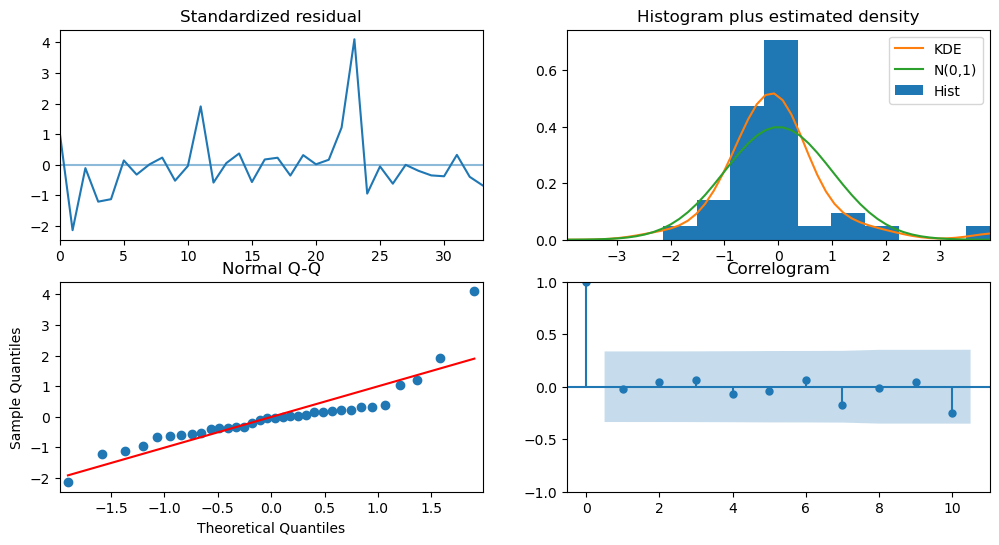

In [35]:
with plt.rc_context():
    plt.rc("figure", figsize=(12, 6))
    model.plot_diagnostics()
    plt.show()

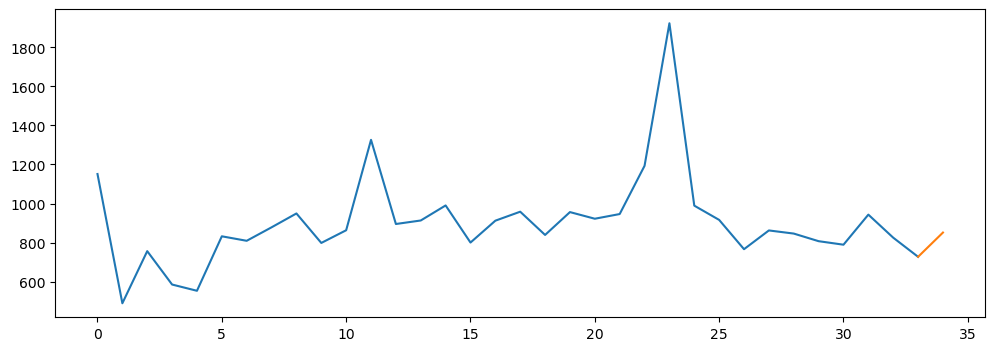

In [50]:
forecast = model.predict(n_periods=int(34 - trial_ex.index[-1]))

with plt.rc_context():
    plt.rc("figure", figsize=(12, 4))
    plt.plot(range(trial_ex.shape[0]), trial_ex['item_cnt_month'])
    plt.plot(range(trial_ex.shape[0] - 1, trial_ex.shape[0] + 34 - trial_ex.index[-1]), 
             [trial_ex['item_cnt_month'].iloc[-1], forecast.iloc[-1]])
    plt.show()

### Prediction

In [31]:
shop_lst = train['shop_id'].unique().tolist()
train_origin = pd.read_csv("./data/sales_train.csv")
per = train_origin.groupby(by=["item_id"])["item_cnt_day"].sum().to_frame(name='item_cnt').reset_index()
col = per["item_cnt"].copy()
per["item_per"] = col / col.sum()
pre_df  = pd.DataFrame(columns=["shop_id", "item_id", "item_cnt_month"])

for i in range(len(shop_lst)):
    trial_ex = trial[trial['shop_id'] == shop_lst[i]].drop(columns=['shop_id'])
    model = auto_arima(trial_ex, start_p=0, start_q=0, start_P=0, start_Q=0)
    forecast = model.predict(n_periods=int(34 - trial_ex.index[-1]))
    try:
        forecast = forecast.iloc[-1]
    except:
        forecast = trial_ex.iloc[0, -1]
    per_example = per[per['item_id'].isin(test.loc[(test['shop_id'] == shop_lst[i]), 'item_id'].unique().tolist())]
    per_example['item_cnt_month'] = per_example['item_per'] * forecast
    per_example['item_cnt_month'] = np.where(per_example['item_cnt_month'] > 20, 20, per_example['item_cnt_month'])
    per_example['item_cnt_month'] = np.where(per_example['item_cnt_month'] < 0, 0, per_example['item_cnt_month'])
    per_example['shop_id'] = shop_lst[i]
    per_example = per_example.drop(columns=["item_per", "item_cnt"])
    pre_df = pd.concat([pre_df, per_example], axis=0)
    
pre_df

/home/fangtian/miniconda3/envs/ann/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/fangtian/miniconda3/envs/ann/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/fangtian/miniconda3/envs/ann/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/fangtian/miniconda3/envs/ann/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  r

,shop_id,item_id,item_cnt_month
30,59,30,0.453507
31,59,31,0.311528
32,59,32,0.454159
33,59,33,0.181490
38,59,38,0.014328
...,...,...,...
21799,36,22162,0.063803
21800,36,22163,0.006846
21801,36,22164,0.045000
21803,36,22166,0.031765


In [35]:
test_arima = pd.merge(test, pre_df, on=['shop_id', 'item_id'], how = "left")
test_arima = test_arima.fillna(value=test_arima['item_cnt_month'].mean())
# test_arima = test_arima.fillna(0)
test_arima 

,ID,shop_id,item_id,item_category_id,date_block_num,price_m,item_cnt_month
0,0,5,5037,19,34,1499.000000,0.428533
1,1,5,5320,55,34,445.207669,0.000000
2,2,5,5233,19,34,1199.000000,0.171076
3,3,5,5232,23,34,1190.433333,0.047577
4,4,5,5268,20,34,445.207669,0.000000
...,...,...,...,...,...,...,...
214195,214195,45,18454,55,34,99.000000,0.087680
214196,214196,45,16188,64,34,1359.000000,0.000678
214197,214197,45,15757,55,34,229.000000,0.062750
214198,214198,45,19648,40,34,89.100000,0.009497


In [36]:
test_arima.isna().sum()

ID                  0
shop_id             0
item_id             0
item_category_id    0
date_block_num      0
price_m             0
item_cnt_month      0
dtype: int64

In [37]:
test_arima = test_arima.loc[:, ['ID', 'item_cnt_month']]
test_arima.to_csv('./results/submission_4.csv', index=False)

## Deep Learning Model

In [3]:
train_X = np.load("./data/train_X.npy")
train_y = np.load("./data/train_y.npy")
test_X = np.load("./data/test_X.npy")

In [8]:
train = train[train['item_cnt_day'] >= 0]
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0
5,2013-01-10,0,25,2564,349.00,1.0
...,...,...,...,...,...,...
2935844,2015-10-10,33,25,7409,299.00,1.0
2935845,2015-10-09,33,25,7460,299.00,1.0
2935846,2015-10-14,33,25,7459,349.00,1.0
2935847,2015-10-22,33,25,7440,299.00,1.0


In [10]:
def dl_model():
    inputs = tf.keras.Input(shape=(train_X.shape[1],))
    x = tf.keras.layers.Dense(64, activation="relu")(inputs)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(16, activation="relu")(x)
    outputs = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.summary()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss="mse", metrics=["mse"])
    return model

tf.keras.backend.clear_session()
model = dl_model()
history = model.fit(x=train_X,
                    y=train_y, 
                    epochs=100, 
                    batch_size=128,
                    validation_split=0.2)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 85)]              0         
                                                                 
 dense (Dense)               (None, 64)                5504      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 6,561
Trainable params: 6,561
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
8961/8961 [==============================] - 8s

KeyboardInterrupt: 

## Hybrid Model